# *(Joglekar, et. al, 2018)*: Inter-areal Balanced Amplification Figure 2

Implementation of the figure 2 of:

- Joglekar, Madhura R., et al. "Inter-areal balanced amplification enhances signal propagation in a large-scale circuit model of the primate cortex." Neuron 98.1 (2018): 222-234.

In [18]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt
import numpy as np
from jax import vmap, jit
from scipy import io as sio
from functools import partial

In [19]:
bm.set_dt(dt=2e-4)

In [35]:
bp.__version__

'2.4.3'

In [20]:

class ThreshLinearModel(bp.NeuGroup):
  def __init__(
      self,
      size, hier, fln, inp_idx, inp_data,
      eta=.68, betaE=.066, betaI=.351, tauE=2e-2, tauI=1e-2,
      omegaEE=24.3, omegaEI=19.7, omegaIE=12.2, omegaII=12.5,
      muIE=25.3, muEE=28., noiseE=None, noiseI=None, seed=None,
      desired_ss=None, name=None
  ):
    super(ThreshLinearModel, self).__init__(size, name=name)

    # parameters
    self.hier = hier
    self.fln = fln
    self.eta = bp.init.parameter(eta, self.num, False)
    self.betaE = bp.init.parameter(betaE, self.num, False)
    self.betaI = bp.init.parameter(betaI, self.num, False)
    self.tauE = bp.init.parameter(tauE, self.num, False)
    self.tauI = bp.init.parameter(tauI, self.num, False)
    self.omegaEE = bp.init.parameter(omegaEE, self.num, False)
    self.omegaEI = bp.init.parameter(omegaEI, self.num, False)
    self.omegaIE = bp.init.parameter(omegaIE, self.num, False)
    self.omegaII = bp.init.parameter(omegaII, self.num, False)
    self.muIE = bp.init.parameter(muIE, self.num, False)
    self.muEE = bp.init.parameter(muEE, self.num, False)
    self.desired_ss = desired_ss
    self.seed = seed
    self.noiseE = bp.init.parameter(noiseE, self.num, True)
    self.noiseI = bp.init.parameter(noiseI, self.num, True)
    self.inp_idx, self.inp_data = inp_idx, inp_data

    # Synaptic weights for intra-areal connections
    self.wEE_intra = betaE * omegaEE * (1 + eta * hier)
    self.wIE_intra = betaI * omegaIE * (1 + eta * hier)
    self.wEI_intra = -betaE * omegaEI
    self.wII_intra = -betaI * omegaII

    # Synaptic weights for inter-areal connections
    self.wEE_inter = bm.asarray(fln.T * (betaE * muEE * (1 + eta * hier))).T
    self.wIE_inter = bm.asarray(fln.T * (betaI * muIE * (1 + eta * hier))).T

    # Variables
    self.re = bm.Variable(bm.zeros(self.num))
    self.ri = bm.Variable(bm.zeros(self.num))

    # get background input
    if desired_ss is None:
      self.bgE = bm.zeros(self.num)
      self.bgI = bm.zeros(self.num)
    else:
      if len(desired_ss) != 2:
        raise ValueError
      if len(desired_ss[0]) != self.num:
        raise ValueError
      if len(desired_ss[1]) != self.num:
        raise ValueError
      self.bgE, self.bgI = self.get_background_current(*desired_ss)

  def get_background_current(self, ssE, ssI):
    # total weights
    wEEaux = bm.diag(-1 + self.wEE_intra) + self.wEE_inter
    wEIaux = self.wEI_intra * bm.eye(self.num)
    wIEaux = bm.diag(self.wIE_intra) + self.wIE_inter
    wIIaux = (-1 + self.wII_intra) * bm.eye(self.num)
    # temp matrices to create matrix A
    A1 = bm.concatenate((wEEaux, wEIaux), axis=1)
    A2 = bm.concatenate((wIEaux, wIIaux), axis=1)
    A = bm.concatenate([A1, A2])
    ss = bm.concatenate((ssE, ssI))
    cur = -bm.dot(A, ss)
    self.re.value, self.ri.value = ssE, ssI
    # state = bm.linalg.lstsq(-A, cur, rcond=None)[0]
    # self.re.value, self.ri.value = bm.split(state, 2)
    return bm.split(cur, 2)

  def reset(self):
    if self.desired_ss is None:
      self.re[:] = 0.
      self.ri[:] = 0.
    else:
      self.re.value = self.desired_ss[0]
      self.ri.value = self.desired_ss[1]

  def update(self):
    tdi = bp.share.get_shargs()
    # E population
    Ie = bm.dot(self.wEE_inter, self.re) + self.wEE_intra * self.re
    Ie += self.wEI_intra * self.ri + self.bgE
    if self.noiseE is not None:
      Ie += self.noiseE * bm.random.randn(self.num) / bm.sqrt(tdi.dt)
    Ie[self.inp_idx] += self.inp_data[tdi['i']]
    self.re.value = bm.maximum(self.re + (-self.re + bm.maximum(Ie, 10.)) / self.tauE * tdi.dt, 0)
    # I population
    Ii = bm.dot(self.wIE_inter, self.re) + self.wIE_intra * self.re
    Ii += self.wII_intra * self.ri + self.bgI
    if self.noiseI is not None:
      Ii += self.noiseI * bm.random.randn(self.num) / bm.sqrt(tdi.dt)
    self.ri.value = bm.maximum(self.ri + (-self.ri + bm.maximum(Ii, 35.)) / self.tauI * tdi.dt, 0)



In [21]:
def simulate(num_node, muEE, fln, hier, input4v1, duration):
  model = ThreshLinearModel(int(num_node),
                            hier=hier, fln=fln,
                            inp_idx=0, inp_data=input4v1, muEE=muEE,
                            desired_ss=(bm.ones(num_node) * 10, bm.ones(num_node) * 35))
  runner = bp.DSRunner(model, monitors=['re'], progress_bar=False, numpy_mon_after_run=False)
  runner.run(duration)
  return runner.mon.ts, runner.mon.re


In [22]:

def show_firing_rates(ax, hist_t, hist_re, show_duration=None, title=None):
  hist_t = bm.as_numpy(hist_t)
  hist_re = bm.as_numpy(hist_re)
  if show_duration is None:
    i_start, i_end = (1.75, 5.)
  else:
    i_start, i_end = show_duration
  i_start = round(i_start / bm.get_dt())
  i_end = round(i_end / bm.get_dt())

  # visualization
  rateV1 = np.maximum(1e-2, hist_re[i_start:i_end, 0] - hist_re[i_start, 0])
  rate24 = np.maximum(1e-2, hist_re[i_start:i_end, -1] - hist_re[i_start, -1])
  ax.semilogy(hist_t[i_start:i_end], rateV1, 'dodgerblue')
  ax.semilogy(hist_t[i_start:i_end], rate24, 'forestgreen')
  ax.set_ylim([1e-2, 1e2 + 100])
  # ax.set_xlim([-0.25, 2.25])
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_ylabel('Change in firing rate  (Hz)', fontsize='large')
  ax.set_xlabel('Time (s)', fontsize='large')
  if title:
    ax.set_title(title)


In [23]:

def show_maximum_rate(ax, muEE_range, peak_rates, title=''):
  ax.semilogy(muEE_range[4], np.squeeze(peak_rates[4]), 'cornflowerblue', marker="o",
              markersize=12, markerfacecolor='w')
  ax.semilogy(muEE_range, np.squeeze(peak_rates), 'cornflowerblue', marker=".", markersize=10)
  ax.semilogy(muEE_range[3], np.squeeze(peak_rates[3]), 'cornflowerblue', marker="x", markersize=15)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_ylim([1e-6, 1e3])
  ax.set_ylabel('Maximum rate in 24c (Hz)', fontsize='large')
  ax.set_xlabel('Global E to E coupling', fontsize='large')
  if title:
    ax.set_title(title)


In [24]:
def figure2B():
  # data
  data = sio.loadmat('Joglekar_2018_data/subgraphData.mat')
  num_node = data['nNodes'][0, 0]
  hier = bm.asarray(data['hierVals'].squeeze() / max(data['hierVals']))  # normalize hierarchical position
  fln = bm.asarray(data['flnMat'])

  # inputs
  ampl = 21.8 * 1.9
  inputs, duration = bp.inputs.section_input([0, ampl, 0], [2., 0.25, 7.75], return_length=True)

  # Fig 2B
  ax = plt.subplot(1, 2, 1)
  times, res = simulate(int(num_node), fln=fln, hier=hier, muEE=34, input4v1=inputs, duration=duration)
  show_firing_rates(ax, hist_t=times, hist_re=res, show_duration=(1.75, 5.), title=r'$\mu$EE=34')
  ax = plt.subplot(1, 2, 2)
  times, res = simulate(int(num_node), fln=fln, hier=hier, muEE=36, input4v1=inputs, duration=duration)
  show_firing_rates(ax, hist_t=times, hist_re=res, show_duration=(1.75, 5.), title=r'$\mu$EE=36')
  plt.show()

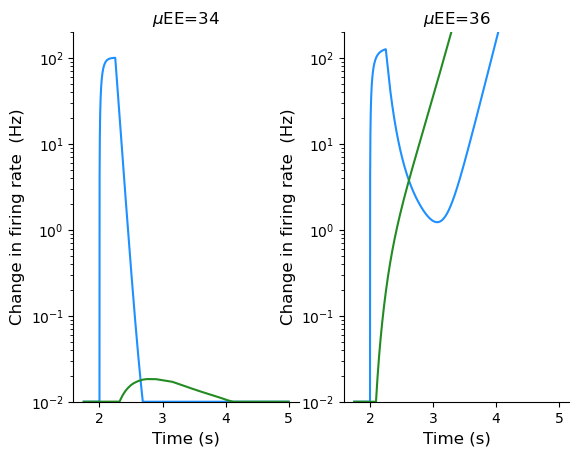

In [25]:
figure2B()

In [26]:

def figure2C():
  # data
  data = sio.loadmat('Joglekar_2018_data/subgraphData.mat')
  hier = bm.asarray(data['hierVals'].squeeze() / max(data['hierVals']))  # normalize hierarchical position
  fln = bm.asarray(data['flnMat'])

  # inputs
  ampl = 21.8 * 1.9
  inputs, duration = bp.inputs.section_input([0, ampl, 0], [2., 0.25, 7.75], return_length=True)

  all_muEE = bm.arange(28, 44, 2)
  i_start, i_end = (round(1.75 / bm.get_dt()), round(5. / bm.get_dt()))

  @jit
  @partial(vmap, in_axes=(0, None))
  def peak_firing_rate(muEE, fln):
    _, res = simulate(fln.shape[0], fln=fln, hier=hier, muEE=muEE,
                      input4v1=inputs, duration=duration)
    return (res[i_start:i_end, -1] - res[i_start, -1]).max()

  # with feedback
  ax = plt.subplot(1, 2, 1)
  area2peak = peak_firing_rate(all_muEE, fln)
  area2peak = bm.where(area2peak > 500, 500, area2peak)
  show_maximum_rate(ax, all_muEE.to_numpy(), area2peak.to_numpy(), title='With feedback')
  # without feedback
  ax = plt.subplot(1, 2, 2)
  area2peak = peak_firing_rate(all_muEE, bm.tril(fln))
  area2peak = bm.where(area2peak > 500, 500, area2peak)
  show_maximum_rate(ax, all_muEE.to_numpy(), area2peak.to_numpy(), title='Without feedback')
  plt.show()



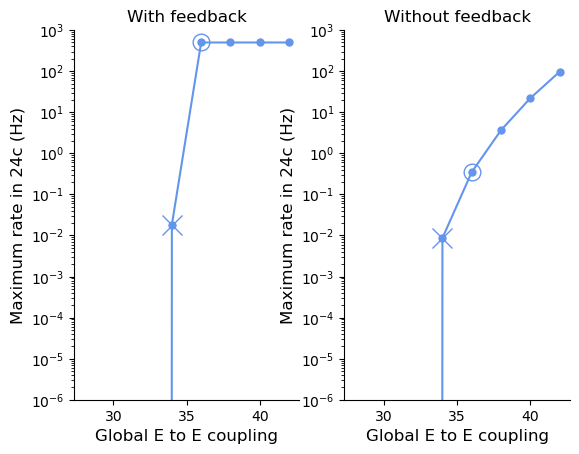

In [27]:
figure2C()

In [28]:

sStrong = 1000
sWeak = 100


def show_multiple_area_rates(axes, times, rates, plot_duration, color='green'):
  t_start, t_end = plot_duration
  i_start, i_end = round(t_start / bm.get_dt()), round(t_end / bm.get_dt())
  areas2plot = [0, 2, 5, 7, 8, 12, 16, 18, 28]
  for i, j in enumerate(areas2plot):
    ax = axes[i]
    ax.plot(times[i_start:i_end] - 100, rates[i_start:i_end, j] - rates[i_start, j], color)
    ax.set_xlim([-98.25, -96])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    peak = (rates[i_start:i_end, j] - rates[i_start, j]).max()
    if j == 0:
      ax.set_ylim([0, 140])
      ax.set_yticks([round(sWeak * peak, 1) / sWeak])
      ax.set_title('Weak GBA')
    else:
      ax.set_ylim([0, 1.2 * peak])
      ax.set_yticks([round(sWeak * peak, 1) / sWeak])
    if i == 4:
      ax.set_ylabel('Change in firing rate  (Hz)', fontsize='large')

In [29]:
def figure3BD():
  # data
  data = sio.loadmat('Joglekar_2018_data/subgraphData.mat')
  hier = bm.asarray(data['hierVals'].squeeze() / max(data['hierVals']))
  fln = bm.asarray(data['flnMat'])
  num_node = fln.shape[0]

  fig, axes = plt.subplots(9, 2)

  # weak GBA
  muEE = 33.7
  omegaEI = 19.7
  ampl = 22.05 * 1.9
  inputs, duration = bp.inputs.section_input([0, ampl, 0], [2., 0.25, 7.75], return_length=True)
  model = ThreshLinearModel(fln.shape[0],
                            hier=hier, fln=fln, inp_idx=0, inp_data=inputs,
                            muEE=muEE, omegaEI=omegaEI,
                            desired_ss=(bm.ones(num_node) * 10, bm.ones(num_node) * 35))
  runner1 = bp.DSRunner(model, monitors=['re'], )
  runner1.run(duration)
  show_multiple_area_rates(times=runner1.mon.ts,
                           rates=runner1.mon.re,
                           plot_duration=(1.25, 5.),
                           axes=[axis[0] for axis in axes])

  # strong GBA
  muEE = 51.5
  omegaEI = 25.2
  ampl = 11.54 * 1.9
  inputs, duration = bp.inputs.section_input([0, ampl, 0], [2., 0.25, 7.75], return_length=True)
  model = ThreshLinearModel(fln.shape[0],
                            hier=hier, fln=fln, inp_idx=0, inp_data=inputs,
                            muEE=muEE, omegaEI=omegaEI,
                            desired_ss=(bm.ones(num_node) * 10, bm.ones(num_node) * 35))
  runner2 = bp.DSRunner(model, monitors=['re'], )
  runner2.run(duration)
  show_multiple_area_rates(times=runner1.mon.ts,
                           rates=runner1.mon.re,
                           plot_duration=(1.75, 5.),
                           axes=[axis[1] for axis in axes],
                           color='green')
  show_multiple_area_rates(times=runner2.mon.ts,
                           rates=runner2.mon.re,
                           plot_duration=(1.75, 5.),
                           axes=[axis[1] for axis in axes],
                           color='purple')
  plt.tight_layout()
  plt.show()

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

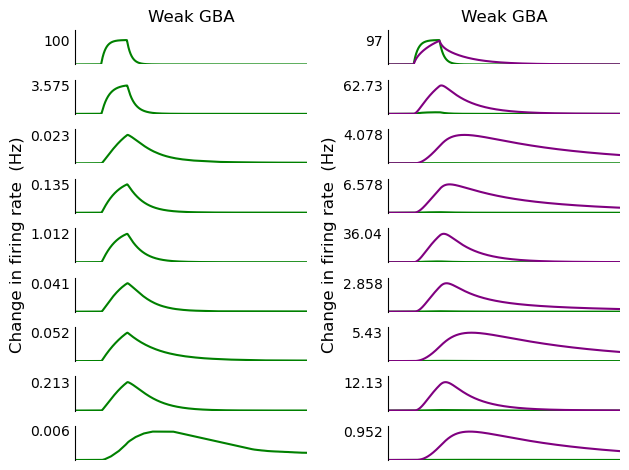

In [30]:
figure3BD()

In [31]:
def figure3E():
  # data
  data = sio.loadmat('Joglekar_2018_data/subgraphData.mat')
  hier = bm.asarray(data['hierVals'].squeeze() / max(data['hierVals']))
  fln = bm.asarray(data['flnMat'])
  num_node = fln.shape[0]
  i_start, i_end = round(1.75 / bm.get_dt()), round(5. / bm.get_dt())

  # weak GBA
  muEE = 33.7
  omegaEI = 19.7
  ampl = 22.05 * 1.9
  inputs, duration = bp.inputs.section_input([0, ampl, 0], [2., 0.25, 7.75], return_length=True)
  model = ThreshLinearModel(fln.shape[0], hier=hier, fln=fln, inp_idx=0, inp_data=inputs, muEE=muEE,
                            omegaEI=omegaEI, desired_ss=(bm.ones(num_node) * 10, bm.ones(num_node) * 35))
  runner1 = bp.DSRunner(model, monitors=['re'], )
  runner1.run(duration)
  peak1 = (runner1.mon.re[i_start: i_end] - runner1.mon.re[i_start]).max(axis=0)

  # strong GBA
  muEE = 51.5
  omegaEI = 25.2
  ampl = 11.54 * 1.9
  inputs, duration = bp.inputs.section_input([0, ampl, 0], [2., 0.25, 7.75], return_length=True)
  model = ThreshLinearModel(fln.shape[0], hier=hier, fln=fln, inp_idx=0, inp_data=inputs, muEE=muEE,
                            omegaEI=omegaEI, desired_ss=(bm.ones(num_node) * 10, bm.ones(num_node) * 35))
  runner2 = bp.DSRunner(model, monitors=['re'], )
  runner2.run(duration)
  peak2 = (runner2.mon.re[i_start: i_end] - runner2.mon.re[i_start]).max(axis=0)

  # visualization
  fig, ax = plt.subplots()
  ax.semilogy(np.arange(0, num_node), 100 * peak1 / peak1[0], 'green', marker=".", markersize=5)
  ax.semilogy(np.arange(0, num_node), 100 * peak2 / peak2[0], 'purple', marker=".", markersize=5)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_ylim([1e-4, 1e2])
  ax.set_xlim([0, num_node])
  ax.legend(['weak GBA', 'strong GBA'], prop={'size': 10}, loc='upper right',
            bbox_to_anchor=(1.0, 1.2), frameon=False)
  ax.set_xticks(np.arange(0, num_node))
  ax.set_xticklabels(data['areaList'].squeeze(), rotation='vertical', fontsize=10)
  plt.show()


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

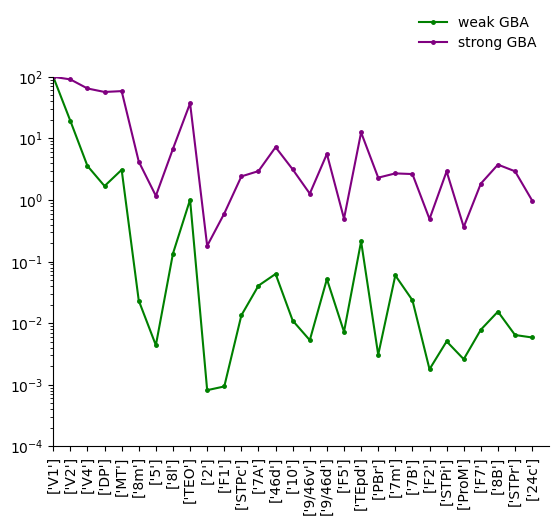

In [32]:
figure3E()

In [33]:
def figure3F():
  # data
  data = sio.loadmat('Joglekar_2018_data/subgraphData.mat')
  hier = bm.asarray(data['hierVals'].squeeze() / max(data['hierVals']))
  fln = bm.asarray(data['flnMat'])
  num_node = fln.shape[0]
  i_start, i_end = round(1.75 / bm.get_dt()), round(3.5 / bm.get_dt())

  # input
  ampl = 22.05 * 1.9
  inputs, duration = bp.inputs.section_input([0, ampl, 0], [2., 0.25, 7.75], return_length=True)

  @partial(vmap, in_axes=(0, None))
  def maximum_rate(muEE, omegaEI=None):
    if omegaEI is None: omegaEI = 19.7 + (muEE - 33.7) * 55 / 178
    model = ThreshLinearModel(num_node, hier=hier, fln=fln, inp_idx=0, inp_data=inputs, muEE=muEE,
                              omegaEI=omegaEI, desired_ss=(bm.ones(num_node) * 10, bm.ones(num_node) * 35))
    runner = bp.DSRunner(model, monitors=['re'], progress_bar=False, numpy_mon_after_run=False)
    runner.run(duration)
    return (runner.mon.re[i_start: i_end, -1] - runner.mon.re[i_start, -1]).max()

  # visualization
  muEErange = bm.arange(20, 52, 2)
  peaks_with_gba = maximum_rate(muEErange, None)
  peaks_without_gba = maximum_rate(muEErange, 19.7)
  peaks_with_gba = bm.where(peaks_with_gba > 500, 500, peaks_with_gba)
  peaks_without_gba = bm.where(peaks_without_gba > 500, 500, peaks_without_gba)
  fig, ax = plt.subplots()
  ax.semilogy(muEErange, peaks_without_gba.to_numpy(), 'cornflowerblue', marker=".", markersize=5)
  ax.semilogy(muEErange, peaks_with_gba.to_numpy(), 'black', marker=".", markersize=5)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_ylim([1e-8, 1e4])
  ax.set_xlim([20, 50])
  ax.set_ylabel('Maximum rate in 24c (Hz)', fontsize='large')
  ax.set_xlabel('Global E to E coupling', fontsize='large')
  plt.show()

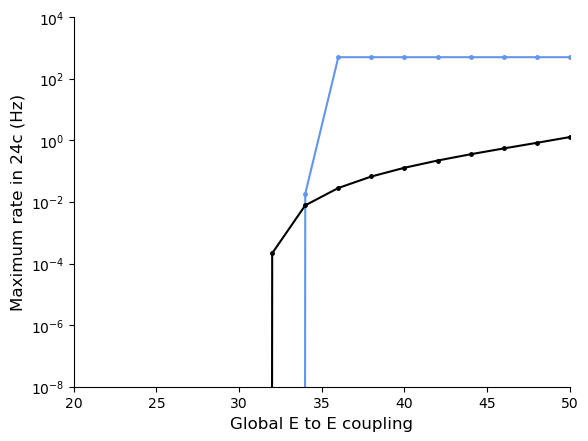

In [34]:
figure3F()